In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

fashion_mnist = input_data.read_data_sets("D:/fashion-mnist/",one_hot = True)

Extracting D:/fashion-mnist/train-images-idx3-ubyte.gz
Extracting D:/fashion-mnist/train-labels-idx1-ubyte.gz
Extracting D:/fashion-mnist/t10k-images-idx3-ubyte.gz
Extracting D:/fashion-mnist/t10k-labels-idx1-ubyte.gz


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
X_train = fashion_mnist.train.images[:5500]
y_train = fashion_mnist.train.labels[:5500]

X_test = fashion_mnist.test.images[:100]
y_test = fashion_mnist.test.labels[:100]

In [0]:
X_train.shape

(5500, 784)

In [0]:
X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

In [0]:
def create_placeholders():
    X = tf.placeholder(tf.float32,[None,28,28,1])
    y = tf.placeholder(tf.float32,[None,10])
    return X,y

In [0]:
X,y = create_placeholders()

In [0]:
def fire(X, squeeze_planes, expand1x1_planes, expand3x3_planes):
    # squeeze_planes: 即filters
    squeeze = tf.layers.conv2d(X,filters = squeeze_planes,kernel_size=1)
    squeeze_ac = tf.nn.relu(squeeze)
    expand1x1 = tf.layers.conv2d(squeeze_ac,expand1x1_planes,kernel_size=1)
    expand1x1_ac = tf.nn.relu(expand1x1)
    
    expand3x3 = tf.layers.conv2d(squeeze_ac,expand3x3_planes,kernel_size=3,padding='same')
    expand3x3_ac = tf.nn.relu(expand3x3)
    
    return tf.concat([expand1x1_ac,expand3x3_ac],axis=1)

In [0]:
def squeeze_net(X):
    conv1 = tf.layers.conv2d(X,96,kernel_size=2,padding='same')
    pool1 = tf.layers.max_pooling2d(conv1,pool_size=2,strides=2)
    
    f1 = fire(pool1,16,32,32)
    f2 = fire(f1,32,48,48)
    f3 = fire(f2,48,96,96)
    f4 = fire(f3,64,128,128)
    
    pool2 = tf.layers.max_pooling2d(f4,pool_size=2,strides=2)
    conv2 = tf.layers.conv2d(pool2,32,kernel_size=2)
    
    # fully connected layer
    flatten = tf.layers.flatten(conv2)
    hid = tf.layers.dense(flatten,64,activation=tf.nn.relu)
    logit = tf.layers.dense(hid,10,activation=tf.nn.relu)
    output = tf.nn.softmax(logit)
    return logit,output

In [0]:
logit,output = squeeze_net(X)

In [0]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logit))
train = tf.train.AdamOptimizer(1e-3).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [0]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
y_train.shape[0]

5500

In [0]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost = []
    for e in range(1):
        for batch in iterate_minibatches(X_train,y_train,batchsize=512,shuffle=True):
            X_batch,y_batch = batch
            sess.run(train,feed_dict={X:X_batch,y:y_batch})
            
            loss_ = sess.run(loss,feed_dict={X:X_batch,y:y_batch})
            cost.append(loss_)
        print('epoch ',e,' : ','loss: ',loss_)

epoch  0  :  loss:  1.3659999


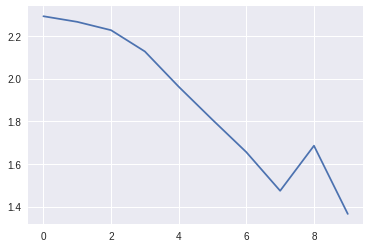

In [0]:
plt.plot(cost)
plt.show()